In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime

In [22]:
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [23]:
data=pd.read_csv('data/Telefonia_movil.csv',parse_dates=True)
data.dtypes

Año                                    int64
Trimestre                              int64
Minutos pospago salientes (miles)     object
Minutos prepago salientes (miles)      int64
Total de minutos salientes (miles)     int64
Periodo                               object
dtype: object

In [24]:
data["Minutos pospago salientes (miles)"] = data["Minutos pospago salientes (miles)"].apply(lambda x: x.replace('.',''))
data["Minutos pospago salientes (miles)"] = data["Minutos pospago salientes (miles)"].astype(int)

In [25]:
data["Periodo"] = data["Año"].map(str) +'Q'+ data["Trimestre"].map(str)
index = pd.PeriodIndex(list(data.Periodo), freq='Q')
data.index = index
data['2017']

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2017Q1,2017,1,14630269,6209983,20840252,2017Q1
2017Q2,2017,2,15315167,6293563,21608730,2017Q2
2017Q3,2017,3,15106275,6308373,21414647,2017Q3
2017Q4,2017,4,14164552,5380710,19545262,2017Q4


We will work with 2 series: Minutos pospago salientes y minutos prepago salientes

In [26]:
y1 = data["Minutos pospago salientes (miles)"]
y2 = data["Minutos prepago salientes (miles)"]

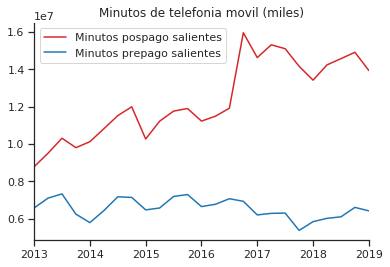

In [27]:
fig, ax= plt.subplots();#figsize=(9,6))
y1.plot(color=red,label = "Minutos pospago salientes")
y2.plot(color=blue,label = "Minutos prepago salientes")
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Minutos de telefonia movil (miles)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
plt.legend()
sns.despine()
plt.show()

Lets do some more explorations! 
Apparently, both variables behave differently over time, so it would be good to analyze them
separately (and possibly applying different models to them).

In [31]:
data['Trimestre'] = data.index.quarter
data['Año'] = data.index.year

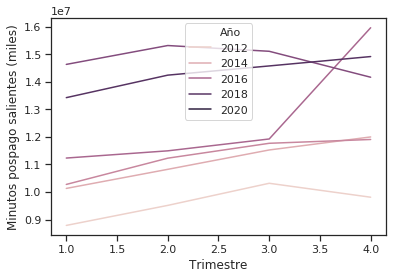

In [34]:
sns.lineplot('Trimestre','Minutos pospago salientes (miles)',hue='Año',data=data, markers='None');


Here we can notice that it has a clear growing tendency over the years.
Although there is not a clear seasonality, we can notice that it grows steadily in the
first trimesters, and then it gets kinda unpredictable.

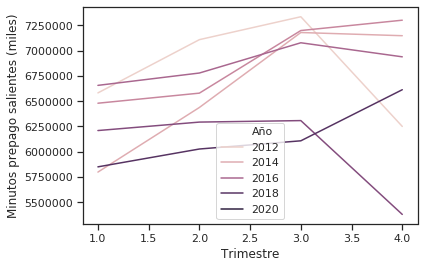

In [36]:
sns.lineplot('Trimestre','Minutos prepago salientes (miles)',hue='Año',data=data, markers='None');

Similar observations for this one, in the third and fourth quarter it gets unpredictable. sometimes grows, sometimes it goes down.

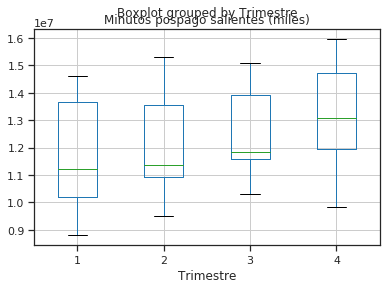

In [41]:
data.boxplot(column='Minutos pospago salientes (miles)',by='Trimestre');

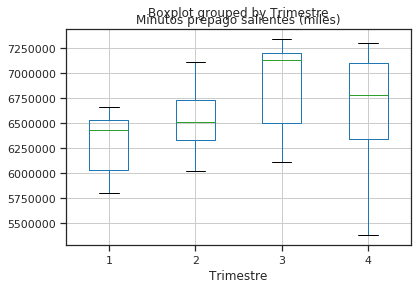

In [42]:
data.boxplot(column='Minutos prepago salientes (miles)',by='Trimestre');

Well, in both diagrams we can observe that the whiskers of the box plots in the fourth trimester
are wider, from 1st to 3rd the boxes are "growing".
Lets do some lag plots to see if we can predict some seasonality, maybe per quartile? The fourth will
fail obviously because it looks really unpredictable in both columns.

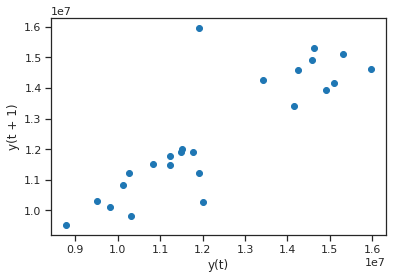

In [55]:
from pandas.plotting import lag_plot
lag_plot(data['Minutos pospago salientes (miles)'],lag=1);

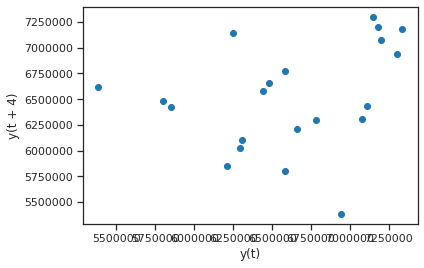

In [64]:
lag_plot(data['Minutos prepago salientes (miles)'],lag=4);

Well, that didn't work for many many values. So maybe, our data is bad and cant be predicted with a
naive model as random walk but we will do our best.

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [90]:
h = 4
test=pd.period_range(start=y1.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y1.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64

To compute interval forecasts, we first estimate the standard deviation of the errors.

In [105]:
resid=y1-y1.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1111026.926

Using the formulas from the lecture, the interval forecasts are as below. 

In [92]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2019Q2,1.175970e+07,1.611484e+07
2019Q3,1.085772e+07,1.701682e+07
2019Q4,1.016560e+07,1.770894e+07
2020Q1,9.582125e+06,1.829242e+07


In [101]:
from pandas.plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y1['2010':],point_pred,intv,intv,intv)


plt.show()

ImportError: cannot import name 'fanchart' from 'pandas.plotting' (/home/lucia/anaconda3/envs/diplodatos/lib/python3.7/site-packages/pandas/plotting/__init__.py)